In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nacc_diag = pd.read_csv('../data/nacc_diagnosis.csv', index_col=0)
nacc_diag.shape

(5209, 1)

In [3]:
res_df = pd.read_csv('latest_output_nacc.csv', index_col=0)
res_df

,mean,std
nacc_id,,
34,0.726221,0.225892
225,0.932158,0.082725
511,0.451389,0.284992
531,0.503501,0.264647
920,0.043539,0.061946
...,...,...
999346,0.988712,0.015708
999546,0.204094,0.156723
999566,0.440869,0.274055


In [4]:
joined_df = res_df.join(nacc_diag, how='inner')
joined_df

,mean,std,diagnosis
nacc_id,,,
34,0.726221,0.225892,AD
225,0.932158,0.082725,OD
511,0.451389,0.284992,AD
531,0.503501,0.264647,OD
920,0.043539,0.061946,Control
...,...,...,...
999346,0.988712,0.015708,AD
999546,0.204094,0.156723,Control
999566,0.440869,0.274055,OND


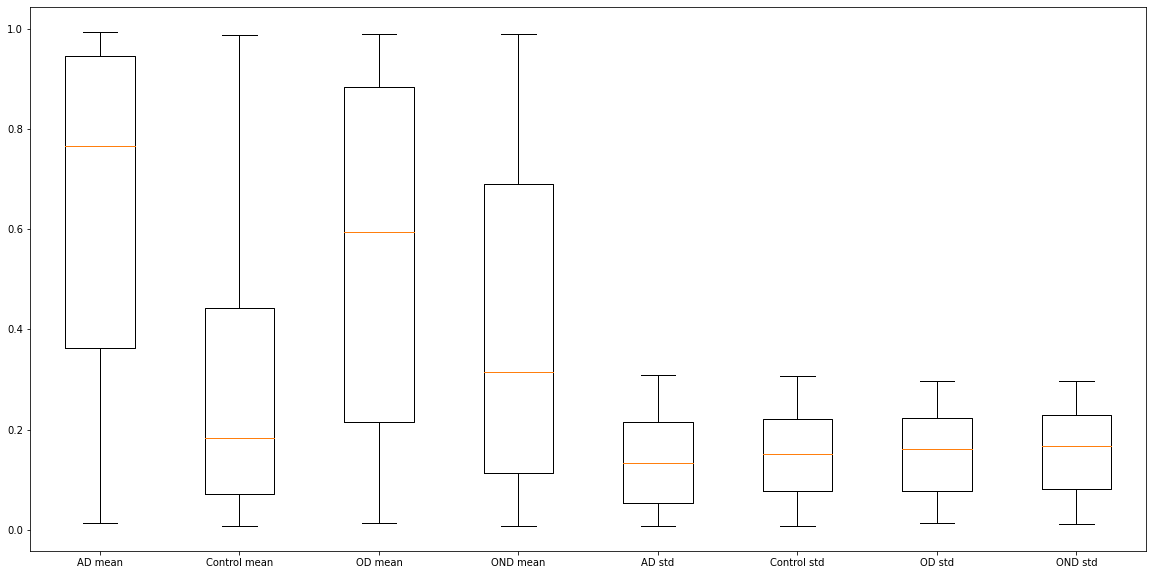

In [12]:
plt.subplots(figsize=(20, 10))
all_data = [joined_df[joined_df.diagnosis == 'AD']['mean'].values, 
            joined_df[joined_df.diagnosis == 'Control']['mean'].values,
            joined_df[joined_df.diagnosis == 'OD']['mean'].values,
            joined_df[joined_df.diagnosis == 'OND']['mean'].values,
            ##
            joined_df[joined_df.diagnosis == 'AD']['std'].values,
            joined_df[joined_df.diagnosis == 'Control']['std'].values,
            joined_df[joined_df.diagnosis == 'OD']['std'].values,
            joined_df[joined_df.diagnosis == 'OND']['std'].values,]


_ = plt.boxplot(all_data, labels=['AD mean', 'Control mean', 'OD mean', 'OND mean', 
                                  'AD std', 'Control std', 'OD std', 'OND std'])
plt.show()
plt.close()

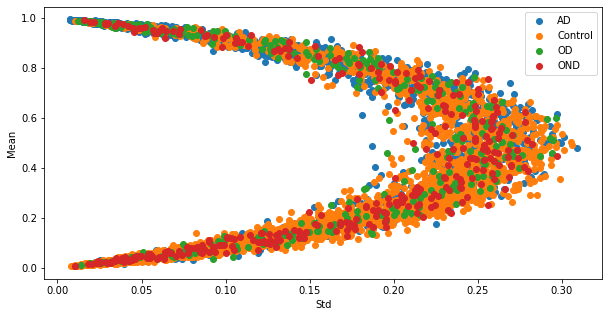

In [21]:
plt.subplots(figsize=(10, 5))

for diagnosis in ['AD', 'Control', 'OD', 'OND']:
    tmp_df = joined_df[joined_df.diagnosis == diagnosis]

    plt.scatter(tmp_df['std'], tmp_df['mean'], label=diagnosis)

plt.legend()
plt.xlabel('Std')
plt.ylabel('Mean')
plt.show()
plt.close()

# Comparing MC-Drop with and without

In [6]:
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


In [29]:
binary_df = joined_df[(joined_df.diagnosis == 'AD') | (joined_df.diagnosis == 'Control')]
binary_df

,mean,std,diagnosis
nacc_id,,,
34,0.726221,0.225892,AD
511,0.451389,0.284992,AD
920,0.043539,0.061946,Control
1006,0.077429,0.092409,Control
1341,0.811785,0.192231,Control
...,...,...,...
998980,0.130548,0.116639,Control
999209,0.146313,0.171141,AD
999346,0.988712,0.015708,AD


In [30]:
binary_df = binary_df.assign(diagnosis_bin =1 - LabelEncoder().fit_transform(binary_df['diagnosis'].copy()))
binary_df

,mean,std,diagnosis,diagnosis_bin
nacc_id,,,,
34,0.726221,0.225892,AD,1
511,0.451389,0.284992,AD,1
920,0.043539,0.061946,Control,0
1006,0.077429,0.092409,Control,0
1341,0.811785,0.192231,Control,0
...,...,...,...,...
998980,0.130548,0.116639,Control,0
999209,0.146313,0.171141,AD,1
999346,0.988712,0.015708,AD,1


In [34]:
single_pass = pd.read_csv('latest_output_nacc_1.csv', index_col=0)
single_pass = single_pass.join(nacc_diag, how='inner')
single_pass = single_pass[(single_pass.diagnosis == 'AD') | (single_pass.diagnosis == 'Control')]
single_pass

,mean,std,diagnosis
nacc_id,,,
34,0.846376,NaN,AD
511,0.462805,NaN,AD
920,0.006656,NaN,Control
1006,0.014642,NaN,Control
1341,0.941566,NaN,Control
...,...,...,...
998980,0.036137,NaN,Control
999209,0.052260,NaN,AD
999346,0.997336,NaN,AD


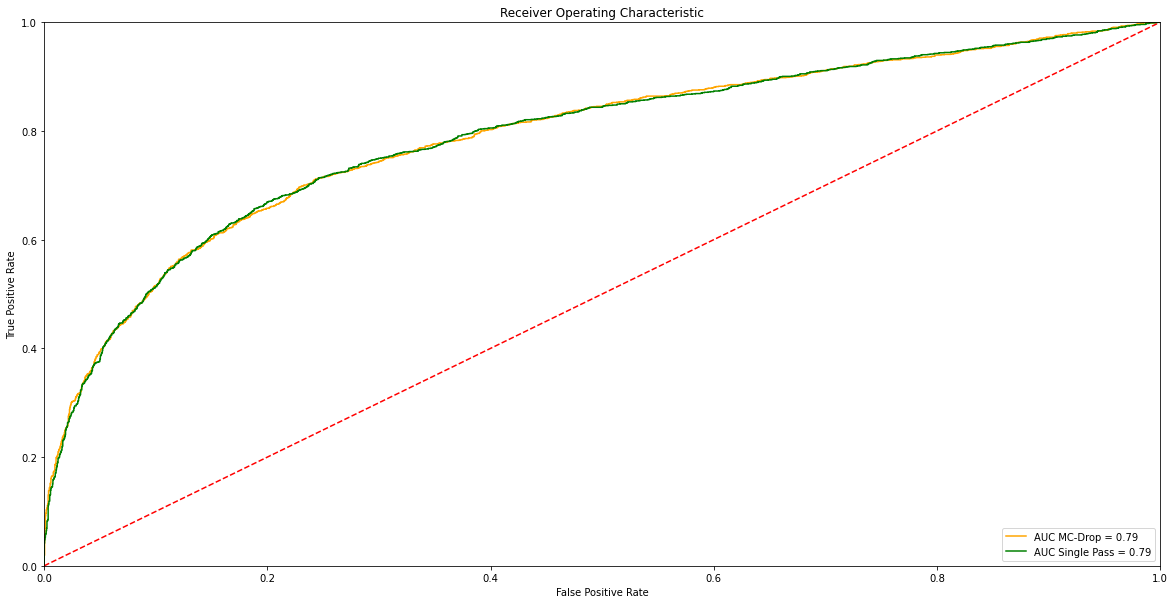

In [45]:

def plot_roc_stuff(tmp_df, label, color):
    preds = tmp_df['mean']
    fpr, tpr, threshold = metrics.roc_curve(1 - LabelEncoder().fit_transform(tmp_df['diagnosis']), preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, 'b', label = f'AUC {label} = %0.2f' % roc_auc, color=color)

plt.subplots(figsize=(20, 10))
plt.title('Receiver Operating Characteristic')
plot_roc_stuff(binary_df, 'MC-Drop', 'orange')
plot_roc_stuff(single_pass, 'Single Pass', 'green')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.close()

# Checking variation on accuracy depending on different thresholds

In [40]:
#tmp_df = binary_df.loc[binary_df['std'] < 0.01, :]
#tmp_df

In [41]:
#probs = tmp_df['mean'].values
#probs[probs < 0.5] = 0
#probs[probs > 0.5] = 1
#probs

In [47]:
tmp_df.shape

(4530, 4)

In [48]:
accs = []
f1s = []
people = []
for std_val in np.arange(0.01, 0.36, 0.01):
    tmp_df = binary_df.loc[binary_df['std'] < std_val, :]
    probs = tmp_df['mean'].values
    probs[probs < 0.5] = 0
    probs[probs > 0.5] = 1
    
    accs.append(metrics.accuracy_score(tmp_df['diagnosis_bin'].values, probs))
    f1s.append(metrics.f1_score(tmp_df['diagnosis_bin'].values, probs))
    people.append(tmp_df.shape[0])

Text(0, 0.5, 'Accuracy achieved')

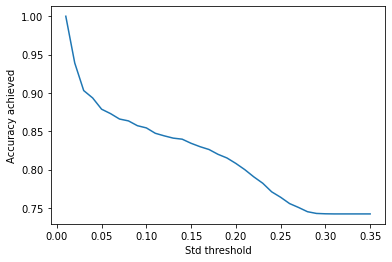

In [65]:
plt.plot(np.arange(0.01, 0.36, 0.01), accs)
plt.xlabel('Std threshold')
plt.ylabel('Accuracy achieved')

Text(0, 0.5, 'Accuracy achieved')

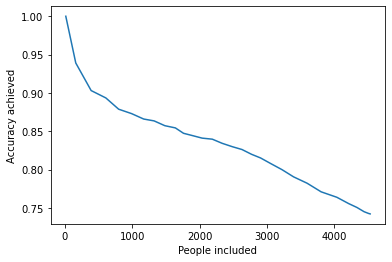

In [66]:
plt.plot(people, accs)
plt.xlabel('People included')
plt.ylabel('Accuracy achieved')

In [53]:
accs_delta = []
f1s_delta = []
people_delta = []
for std_val in np.arange(0.01, 0.51, 0.01):
    tmp_df = binary_df.loc[(binary_df['mean'] < std_val) | (binary_df['mean'] > 1- std_val), :]
    
    probs = tmp_df['mean'].values
    probs[probs < 0.5] = 0
    probs[probs > 0.5] = 1
    
    accs_delta.append(metrics.accuracy_score(tmp_df['diagnosis_bin'].values, probs))
    f1s_delta.append(metrics.f1_score(tmp_df['diagnosis_bin'].values, probs))
    people_delta.append(tmp_df.shape[0])

Text(0, 0.5, 'Accuracy achieved')

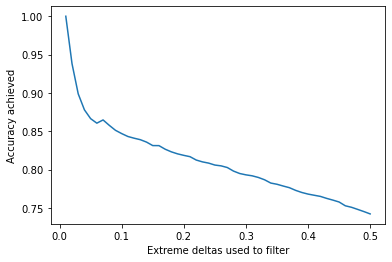

In [68]:
plt.plot(np.arange(0.01, 0.51, 0.01), accs_delta)
plt.xlabel('Extreme deltas used to filter')
plt.ylabel('Accuracy achieved')

## Comparing the two approaches on people X performance

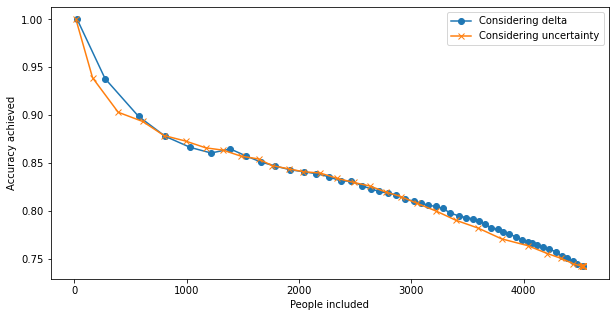

In [63]:
plt.subplots(figsize=(10,5))
plt.plot(people_delta, accs_delta, 'o-', label='Considering delta')
plt.plot(people, accs, 'x-', label='Considering uncertainty')
plt.xlabel('People included')
plt.ylabel('Accuracy achieved')
plt.legend()

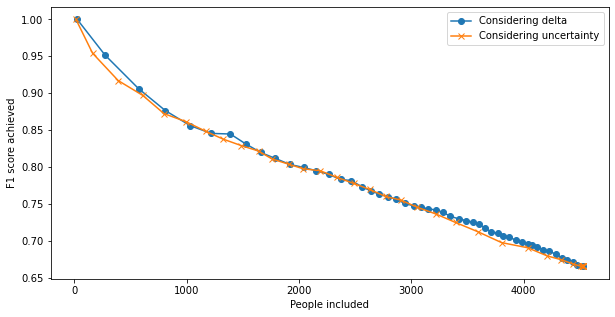

In [64]:
plt.subplots(figsize=(10,5))
plt.plot(people_delta, f1s_delta, 'o-', label='Considering delta')
plt.plot(people, f1s, 'x-', label='Considering uncertainty')
plt.xlabel('People included')
plt.ylabel('F1 score achieved')
plt.legend()